# Homework 3. 
# I. Decision Tree.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Разделение-на-train,-test" data-toc-modified-id="Разделение-на-train,-test-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Разделение на train, test</a></span></li><li><span><a href="#Fit-MyDecisionTree" data-toc-modified-id="Fit-MyDecisionTree-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fit MyDecisionTree</a></span></li><li><span><a href="#Predict-MyDecisionTree" data-toc-modified-id="Predict-MyDecisionTree-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Predict MyDecisionTree</a></span></li><li><span><a href="#Train-with-sklearn" data-toc-modified-id="Train-with-sklearn-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train with sklearn</a></span></li><li><span><a href="#Сравнение-метрик" data-toc-modified-id="Сравнение-метрик-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Сравнение метрик</a></span></li></ul></div>

# Задание  

1. Напишите свой алгоритм построения дерева решений для задачи бинарной классификации.  
    - критерий информативности - Энтропия Шеннона
    - критерии останова - максимальная глубина, кол-во элементов в листе, прирост энтропии < x
2. Сравните результат работы своего алгоритма с sklearn    

## Подготовка данных
Рассмотрим задачу "Титаник" https://www.kaggle.com/c/titanic/data. Необходимо предсказать выживет пассажир или нет.

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix 

In [2]:
# считаем данные из файла в pandas DataFrame
df = pd.read_csv("train.csv")

# зафиксируем целевую переменную и удалим ее из данных
y = df['Survived']
df.drop('Survived', axis=1, inplace=True)

In [3]:
# удалим признаки PassengerId, Name, Ticket и Cabin из данных
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# заполним пропуски в признаке Age обучающей выборки медианным значением
df['Age'].fillna(df['Age'].median(), inplace=True)

#заполним пропуски в признаке Embarked обучающей выборки самыми частыми значениями этого признака
df['Embarked'].fillna(df['Embarked'].value_counts().idxmax(), inplace=True)

#заменим категориальные признаки, используя One-Hot-Encoding
categorical = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
df = pd.concat([df, pd.get_dummies(df[categorical], columns=categorical, drop_first=True)],axis=1)

df.drop(categorical, axis=1, inplace=True)

In [4]:
df.head()

,Age,Fare,Pclass_2,Pclass_3,Sex_male,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_Q,Embarked_S
0,22.0,7.2500,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,38.0,71.2833,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,26.0,7.9250,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,35.0,53.1000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,35.0,8.0500,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Разделение на train, test

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.1, random_state = 13)

In [6]:
print ('Train: ' + str(len(X_train)))
print ('Test: ' + str(len(X_test)))

Train: 801
Test: 90


In [7]:
print(len(df['Fare'].value_counts()) )
print( len(df['Pclass_2'].value_counts()) )

248
2


## Fit MyDecisionTree  
Напишите свою функцию построения дерева.

Структуру дерева можно задать, например, словарем следующего вида:  
```python
{'feature_name': 'Age', # название фичи 
'threshold': 20, # порог разбиения
'left': 0,  # ссылка на левое поддерево, задан доминирующий класс
'right': 1} # ссылка на правое поддерево, задан доминирующий класс
```

In [8]:
def get_target(target):
    """
        Функция ищет доминирующий класс во входном DataFrame
        Input - DataFrame
        Output - 0 или 1
        
        Например, в исходных данных 490 нулей и 311 единиц.
        Функция должна вернуть 0.
    """ 
    x = target.value_counts().index[0]
    return x

In [9]:
def get_entropy(data):
    """
        Функция считает энтропию заданного множества.
        Input - таргет (тип - pandas.core.series.Series)
        
        Output - значение энтропии (тип - float)
    """
    # YOUR CODE HERE
    
    target = data['target'].copy() # Подсчет вероятностей для разных классов в target
    
    entropy = 0 
    
    p = np.unique(target, return_counts = True)[1]/len(target)
    entropy = (-(p*np.log2(p))).sum()
    
    return entropy

In [10]:
def feature_separation(X, f_name):
    """
        Функция ищет лучшее разбиение для данной фичи.
        Input - df: DataFrame с 2 атрибутами (feature, target), 
                f_name: название фичи (для которой ищем разбиение)
                
        Output - прирост энтропии, порог разбиения
    """
    
    # YOUR CODE HERE
    
    # Сортируем датафрейм
    data = X.sort_values(f_name, ascending = False)
    # Находим энтропию всей выборки
    s_0 = get_entropy(X)
    
    delta_entropy = 0
    threshold = 0
    
    n = len(X['target'])
    
    # Ищем разбиение с максимальным значением энтропии
    for i in range(n - 1):
        s_1 = data[:i + 1]
        s_2 = data[i + 1:]
        n_1 = len(data.target[:i + 1])
        n_2 = len(data.target[i + 1:])
            
        IG = s_0 - (n_1/n*get_entropy(s_1) + n_2/n*get_entropy(s_2) )
        
        # Случай, когда признак не бинарный
        if len(data[f_name].value_counts())!=2:
            if IG > delta_entropy:
                delta_entropy = IG
                threshold = data[f_name][i+1:i+2].values[0]
        
        # Когда признак бинарный нужно делить по границе нулей и единиц.
        elif (data[f_name][i:i+1].values[0] > data[f_name][i+1:i+2].values[0]) :
                delta_entropy = IG
                threshold = 0          
            
    print(f' Max {f_name}  thr =   {threshold}    entr = {round(delta_entropy, 4)}' )
    return (delta_entropy, threshold)

In [11]:
def best_separation(X):
    """
        Функция выбирает фичу для разбиения, которая даст максимальный прирост энтропии.
        Input - исходный DataFrame
        
        Output - словарь следующиего вида
        {'feature_name': sep_feature, 'threshold': threshold, 'groups': groups}
        
            sep_feature - название фичи для разбиения (тип - String)
            threshold - порог разбиения (тип - float)
            groups - tuple из двух поддеревьев (df_left, df_right)
    """
    
    sep_feature, threshold, groups = None, None, X
    all_features = [c for c in df.columns.tolist() if c != 'target']

    max_entropy = 0
    
    for f in all_features:
        # YOUR CODE HERE
        # Определяем границу разбиения
        entropy, thr = feature_separation(X, f)
        
        if ( max_entropy < entropy):
            max_entropy = entropy
            # Разделяем по границе не бинарного признака
            if len(X[f].value_counts())!=2:
                sep_feature, threshold, groups = f, thr, (X[X[f] < thr], X[X[f]>=thr ])
            else:
                sep_feature, threshold, groups = f, thr, (X[X[f] == thr], X[X[f] != thr ])
            
    print('best feature = ', sep_feature)
    return {'feature_name': sep_feature, 'threshold': threshold, 'groups': groups}

In [12]:
def split(node, max_depth, depth):
    """
        Рекурсивная функция для построения дерева
        Input - node: корень дерева
                max_depth: максимальная глубина дерева
                depth: текущая глубина дерева
    """
    
    df_left, df_right = node['groups']
    sep_feature = node['feature_name']
    del(node['groups'])
    
    # проверяем, есть ли разбиение
    if len(df_left) == 0 or len(df_right) == 0:
        node['left'] = node['right'] = None  # YOUR CODE HERE
        return
    
    # проверяем максимальную глубину
    if depth >= max_depth:
        # Ставим самые частые значения
        node['left'], node['right'] = get_target(df_left['target']), get_target(df_right['target'])
        return
    
    else:
        
        
        node['left'] = best_separation(df_left) #ставим ссылку на поддерево
        split(node['left'], max_depth, depth + 1)
        

        node['right'] = best_separation(df_right) # ставим ссылку на поддерево
        split(node['right'], max_depth, depth + 1)

In [13]:
def fit_my_tree(X, max_depth):
    """
        Функция для обучения дерева
        Input - df: DataFrame
                max_depth: максимальная глубина дерева
    """    
    root = best_separation(X)
    split(root, max_depth, 1)

    return root

In [19]:
X = X_train.copy()
X['target']=y_train # Возвращаем на место таргет
my_tree = fit_my_tree(X, 5)

 Max Age  thr =   6.0    entr = 0.0149
 Max Fare  thr =   15.5    entr = 0.0618
 Max Pclass_2  thr =   0    entr = 0.0031
 Max Pclass_3  thr =   0    entr = 0.0692
 Max Sex_male  thr =   0    entr = 0.212
 Max SibSp_1  thr =   0    entr = 0.0224
 Max SibSp_2  thr =   0    entr = 0.0009
 Max SibSp_3  thr =   0    entr = 0.0018
 Max SibSp_4  thr =   0    entr = 0.0039
 Max SibSp_5  thr =   0    entr = 0.0036
 Max SibSp_8  thr =   0    entr = 0.0062
 Max Parch_1  thr =   0    entr = 0.0107
 Max Parch_2  thr =   0    entr = 0.0026
 Max Parch_3  thr =   0    entr = 0.002
 Max Parch_4  thr =   0    entr = 0.0036
 Max Parch_5  thr =   0    entr = 0.0007
 Max Parch_6  thr =   0    entr = 0.0078
 Max Embarked_Q  thr =   0    entr = 0.0004
 Max Embarked_S  thr =   0    entr = 0.0205
best feature =  Sex_male
 Max Age  thr =   28.0    entr = 0.0211
 Max Fare  thr =   46.9    entr = 0.0753
 Max Pclass_2  thr =   0    entr = 0.033
 Max Pclass_3  thr =   0    entr = 0.1867
 Max Sex_male  thr =   0   

 Max Pclass_3  thr =   0    entr = 0.0199
 Max Sex_male  thr =   1    entr = 0.0179
 Max SibSp_1  thr =   0    entr = 0.0175
 Max SibSp_2  thr =   0    entr = 0.0
 Max SibSp_3  thr =   0    entr = 0.0024
 Max SibSp_4  thr =   0    entr = 0.0017
 Max SibSp_5  thr =   0    entr = 0.0018
 Max SibSp_8  thr =   0    entr = 0.0024
 Max Parch_1  thr =   0    entr = 0.0077
 Max Parch_2  thr =   0    entr = 0.0058
 Max Parch_3  thr =   0    entr = 0.0006
 Max Parch_4  thr =   0    entr = 0.0012
 Max Parch_5  thr =   0    entr = 0.0006
 Max Parch_6  thr =   0    entr = 0.0179
 Max Embarked_Q  thr =   0    entr = 0.0044
 Max Embarked_S  thr =   0    entr = 0.004
best feature =  Fare
 Max Age  thr =   12.0    entr = 0.079
 Max Fare  thr =   7.8958    entr = 0.0134
 Max Pclass_2  thr =   0    entr = 0.0001
 Max Pclass_3  thr =   0    entr = 0.0002
 Max Sex_male  thr =   1    entr = 0.0187
 Max SibSp_1  thr =   0    entr = 0.0221
 Max SibSp_2  thr =   0    entr = 0.0001
 Max SibSp_3  thr =   0    en

ValueError: too many values to unpack (expected 2)

## Predict MyDecisionTree  

In [20]:
def predict_raw(row, tree):
    """
        Функция предсказывает класс для 1 строки DataFrame.
        
        Input - row: строка DataFrame
                tree: обученное дерево на предыдущем шаге (тип - dict)
    """    
    if row[tree['feature_name']] <= tree['threshold']:
        if type(tree['left']) == dict:
            return predict_raw(row, tree['left'])
        else:
            return tree['left']
    else:
        if type(tree['right']) == dict:
            return predict_raw(row, tree['right'])
        else:
            return tree['right']
    
    
def predict_my_tree(df, tree):
    """
        Функция предсказывает класс для исходного DataFrame.
        
        Input - df: исходный DataFrame
                tree: обученное дерево на предыдущем шаге (тип - dict)
                
        Output - предсказанные классы (тип - pandas.core.series.Series)
    """      
    predict = pd.Series()   
    for index, row in df.iterrows():
        prediction = pd.Series(predict_raw(row, my_tree), [index])
        predict = predict.append(prediction)    
        
    return predict

In [21]:
my_pred_test = predict_my_tree(X_test, my_tree)
my_pred_train = predict_my_tree(X_train, my_tree)
my_pred_train.value_counts()

NameError: name 'my_tree' is not defined

## Train with sklearn 

Обучите дерево, используя библиотеку sklearn. Задайте те же параметры, что и при обучении своего дерева.  

Сравните метрики и попробуйте улучшить ваше дерево.

In [31]:
from sklearn.tree import DecisionTreeClassifier

In [32]:
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth= 5, random_state=0)

# обучаем дерево
clf_tree.fit(X_train, y_train)

# предсказание на тестовой и обучающей выборках
y_pred_test = clf_tree.predict(X_test)
y_pred_train = clf_tree.predict(X_train)

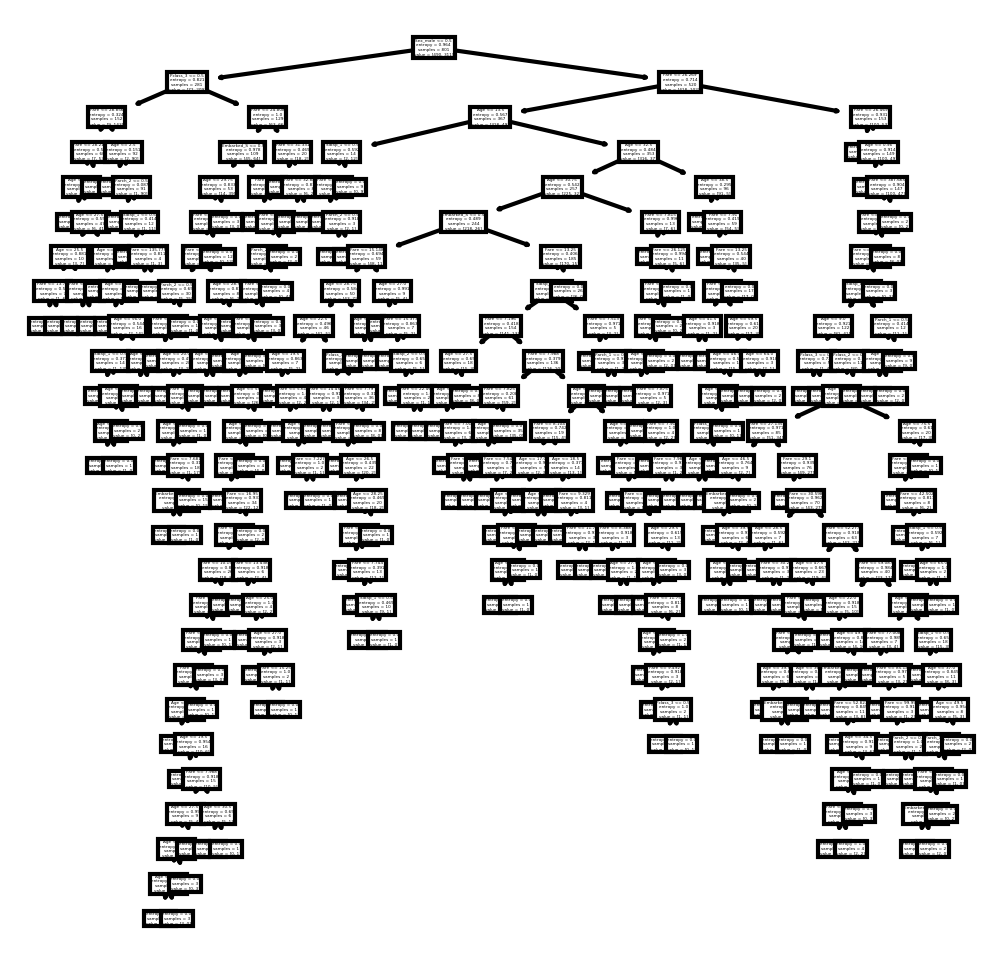

In [49]:
import matplotlib.pyplot as plt
import sklearn.tree as tree
#Отрисовать дерево можно вот так:   
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(clf_tree, feature_names = X_train.columns);

## Сравнение метрик

In [38]:
# метрики при обучении, используя библиотеку sklearn
skl_roc_train = roc_auc_score(y_train, y_pred_train)
skl_roc_test = roc_auc_score(y_test, y_pred_test)

# метрики при обучении, используя собственный алгоритм
my_roc_train = roc_auc_score(y_train, my_pred_train)
my_roc_test = roc_auc_score(y_test, my_pred_test)

In [40]:
assert abs(my_roc_test - 0.6) >= 0.2

In [39]:
my_roc_test

0.8523783488244943

In [41]:
skl_roc_test

0.8261344997266267

In [42]:
y_test.sum()

31

In [45]:
y_pred_test.sum()

37

In [46]:
my_pred_test.sum()

31